# Creating a map of the attractions in the PortAventura theme park

In [1]:
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt 

from scipy.optimize import minimize

import random

In [3]:
link_attraction = pd.read_csv('data/link_attraction_park.csv', sep=';')


In [4]:
attractions = link_attraction['ATTRACTION']

unique_attractions = list(attractions.unique())

In [5]:
class ThemeParkGraph:
    def __init__(self, attractions):
        self.G = nx.Graph()
        self.attractions = attractions
        self.G.add_nodes_from(attractions)
        self.manual_distances = {}
        
    def add_manual_distance(self, attraction1, attraction2, distance):
        key = tuple(sorted([attraction1, attraction2]))
        self.manual_distances[key] = distance
        
    def get_distance(self, attr1, attr2):
        key = tuple(sorted([attr1, attr2]))
        return self.manual_distances.get(key, random.randint(50, 300))
    
    def generate_paths(self, connections_per_attraction=(2, 4)):
        min_connections, max_connections = connections_per_attraction
        paths = []
        
        for i, attr1 in enumerate(self.attractions):
            num_connections = random.randint(min_connections, max_connections)
            possible_connections = self.attractions[i+1:]
            
            if len(possible_connections) > 0:
                num_connections = min(num_connections, len(possible_connections))
                for attr2 in random.sample(possible_connections, num_connections):
                    distance = self.get_distance(attr1, attr2)
                    paths.append((attr1, attr2, distance))
        
        self.G.add_weighted_edges_from(paths)

    def stress_majorization_layout(self):
        """Create a layout that tries to respect actual distances"""
        def stress(pos_flat):
            pos = pos_flat.reshape(-1, 2)
            stress_sum = 0
            
            for (u, v, d) in self.G.edges(data=True):
                u_idx = list(self.G.nodes()).index(u)
                v_idx = list(self.G.nodes()).index(v)
                target_dist = d['weight']
                actual_dist = np.linalg.norm(pos[u_idx] - pos[v_idx])
                stress_sum += (target_dist - actual_dist) ** 2
                
            return stress_sum

        # Start with random positions
        initial_pos = np.random.rand(len(self.G.nodes()), 2)
        
        # Optimize positions
        result = minimize(stress, initial_pos.flatten(), method='L-BFGS-B')
        final_pos = result.x.reshape(-1, 2)
        
        # Convert to dictionary format
        return {node: pos for node, pos in zip(self.G.nodes(), final_pos)}
    
    def visualize(self, use_distance_layout=True, figsize=(20, 20)):
        plt.figure(figsize=figsize)
        
        # Choose layout method
        if use_distance_layout:
            pos = self.stress_majorization_layout()
        else:
            pos = nx.kamada_kawai_layout(self.G)
        
        # Scale positions to be more readable
        pos_array = np.array(list(pos.values()))
        pos_scaled = {node: (coords * 2 - 1) for node, coords in pos.items()}
        
        # Draw nodes
        nx.draw_networkx_nodes(self.G, pos_scaled, 
                             node_color='lightblue',
                             node_size=2000, 
                             alpha=0.7)
        
        # Draw edges with colors based on distance
        edges = self.G.edges(data=True)
        weights = [d['weight'] for (u, v, d) in edges]
        min_weight, max_weight = min(weights), max(weights)
        
        # Normalize weights for coloring
        norm_weights = [(w - min_weight) / (max_weight - min_weight) for w in weights]
        edge_colors = plt.cm.viridis(norm_weights)
        
        nx.draw_networkx_edges(self.G, pos_scaled, 
                             width=2,
                             edge_color=edge_colors,
                             alpha=0.6)
        
        # Add node labels
        labels = {node: '\n'.join(node.split()) for node in self.G.nodes()}
        nx.draw_networkx_labels(self.G, pos_scaled, 
                              labels,
                              font_size=8,
                              font_weight='bold')
        
        # Add edge labels
        edge_labels = nx.get_edge_attributes(self.G, 'weight')
        nx.draw_networkx_edge_labels(self.G, pos_scaled, 
                                   edge_labels,
                                   font_size=6)
        
        plt.title("Port Aventura Theme Park Attractions Graph\nShowing approximate walking distances (meters)", 
                 pad=20,
                 size=16)
        
        # Add colorbar legend
        sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                                  norm=plt.Normalize(vmin=min_weight, vmax=max_weight))
        plt.colorbar(sm, label='Distance (meters)')
        
        plt.axis('off')
        plt.tight_layout()
        plt.show()

In [6]:
unique_attractions

['Aeroplane Ride',
 'Bumper Cars',
 'Bungee Jump',
 'Circus Train',
 'Crazy Bus',
 'Crazy Dance',
 'Dizzy Dropper',
 'Drop Tower',
 'Flying Coaster',
 'Free Fall',
 'Giant Wheel',
 'Giga Coaster',
 'Go-Karts',
 'Gondola',
 'Haunted House',
 'Himalaya Ride',
 'Inverted Coaster',
 'Kiddie Coaster',
 'Log Flume',
 'Merry Go Round',
 'Monorail',
 'Oz Theatre',
 'Pirate Ship',
 'Power Tower',
 'Rapids Ride',
 'Reverse Bungee',
 'Roller Coaster',
 'Scooby Doo',
 'Skyway',
 'Sling Shot',
 'Spinning Coaster',
 'Spiral Slide',
 'Superman Ride',
 'Swing Ride',
 'Tilt-A-Whirl',
 'Top Spin',
 'Vertical Drop',
 'Water Ride',
 'Zipline']

In [7]:
essential_distances = [
    # Main path through thrill rides
    ('Roller Coaster', 'Giga Coaster', 1500),  # Red force, Dragon Khan
    ('Giga Coaster', 'Inverted Coaster', 150),  # Dragon Khan, Shambhala
    ('Inverted Coaster', 'Flying Coaster', 900),  # Shambhala, Stampida
    ('Flying Coaster', 'Superman Ride', 800),  # Furius Baco    
    
    # Water ride section
    ('Water Ride', 'Log Flume', 400),  # Ciclon Tropical, silver river flume
    ('Log Flume', 'Rapids Ride', 300),  # silver river flume, El Torente
    ('Rapids Ride', 'Roller Coaster', 650),  # El Torente, Red force
    
    # Drop ride section
    ('Drop Tower', 'Free Fall', 450),  # Hurakan Condor, King Khajuna
    ('Free Fall', 'Power Tower', 850),  # King Khajuna, Thrill towers
    ('Power Tower', 'Vertical Drop', 1000),  # Thrill towers, El Salto de Blas
    ('Vertical Drop', 'Giga Coaster', 500),  # El salto de Blas, Dragon Khan
    
    # Family rides section
    ('Merry Go Round', 'Circus Train', 1000),  # carousel, sesmoventura station
    ('Circus Train', 'Kiddie Coaster', 100),  # sesmoventura station, tami tami
    ('Kiddie Coaster', 'Crazy Bus', 50),  # tami tami, coco piloto
    ('Crazy Bus', 'Scooby Doo', 25),  # coco piloto, La Granja De Elmo
    ('Scooby Doo', 'Water Ride', 240),  # La Granja De Elmo, tutuki splash 
    
    # Flat rides section
    ('Bumper Cars', 'Go-Karts', 850),  # Buffalo rodeo, Maranello Grand race 
    ('Go-Karts', 'Crazy Dance', 750),  # Maranello grand race, Aloha Tahiti
    ('Crazy Dance', 'Tilt-A-Whirl', 450),  # Aloha Tahiti, Tea cups
    ('Tilt-A-Whirl', 'Spinning Coaster', 600),  # Tea cups, Volpaiute
    ('Spinning Coaster', 'Drop Tower', 220),  # Volpaiute, Hurakan Condor
    
    # Transportation/Special attractions
    ('Monorail', 'Skyway', 400),  # coco piloto, furius baco
    ('Skyway', 'Gondola', 1000),  # furius baco, hurakan condor (beside)
    ('Gondola', 'Zipline', 10),  # hurakan condor (beside), beside 
    ('Zipline', 'Bungee Jump', 300),
    ('Bungee Jump', 'Sling Shot', 300),  # hard to find sling shot and bungee
    
    # Cross-connections for spatial accuracy
    ('Merry Go Round', 'Bumper Cars', 350),  # carousel, buffalo rodeo
    ('Water Ride', 'Monorail', 1000),  # ciclon tropical, coco piloto
    ('Superman Ride', 'Sling Shot', 800),  # Furius Baco, hurakan condor
    ('Rapids Ride', 'Gondola', 600),  # El Torente, hurakan condor
    ('Spinning Coaster', 'Flying Coaster', 800)  # Volpaiute, Furius Baco
]


### A graph of the attractions in both Tivoli Gardens and Port Aventura

C:\Users\35387\AppData\Local\Temp\ipykernel_2224\452421731.py:110: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Distance (meters)')


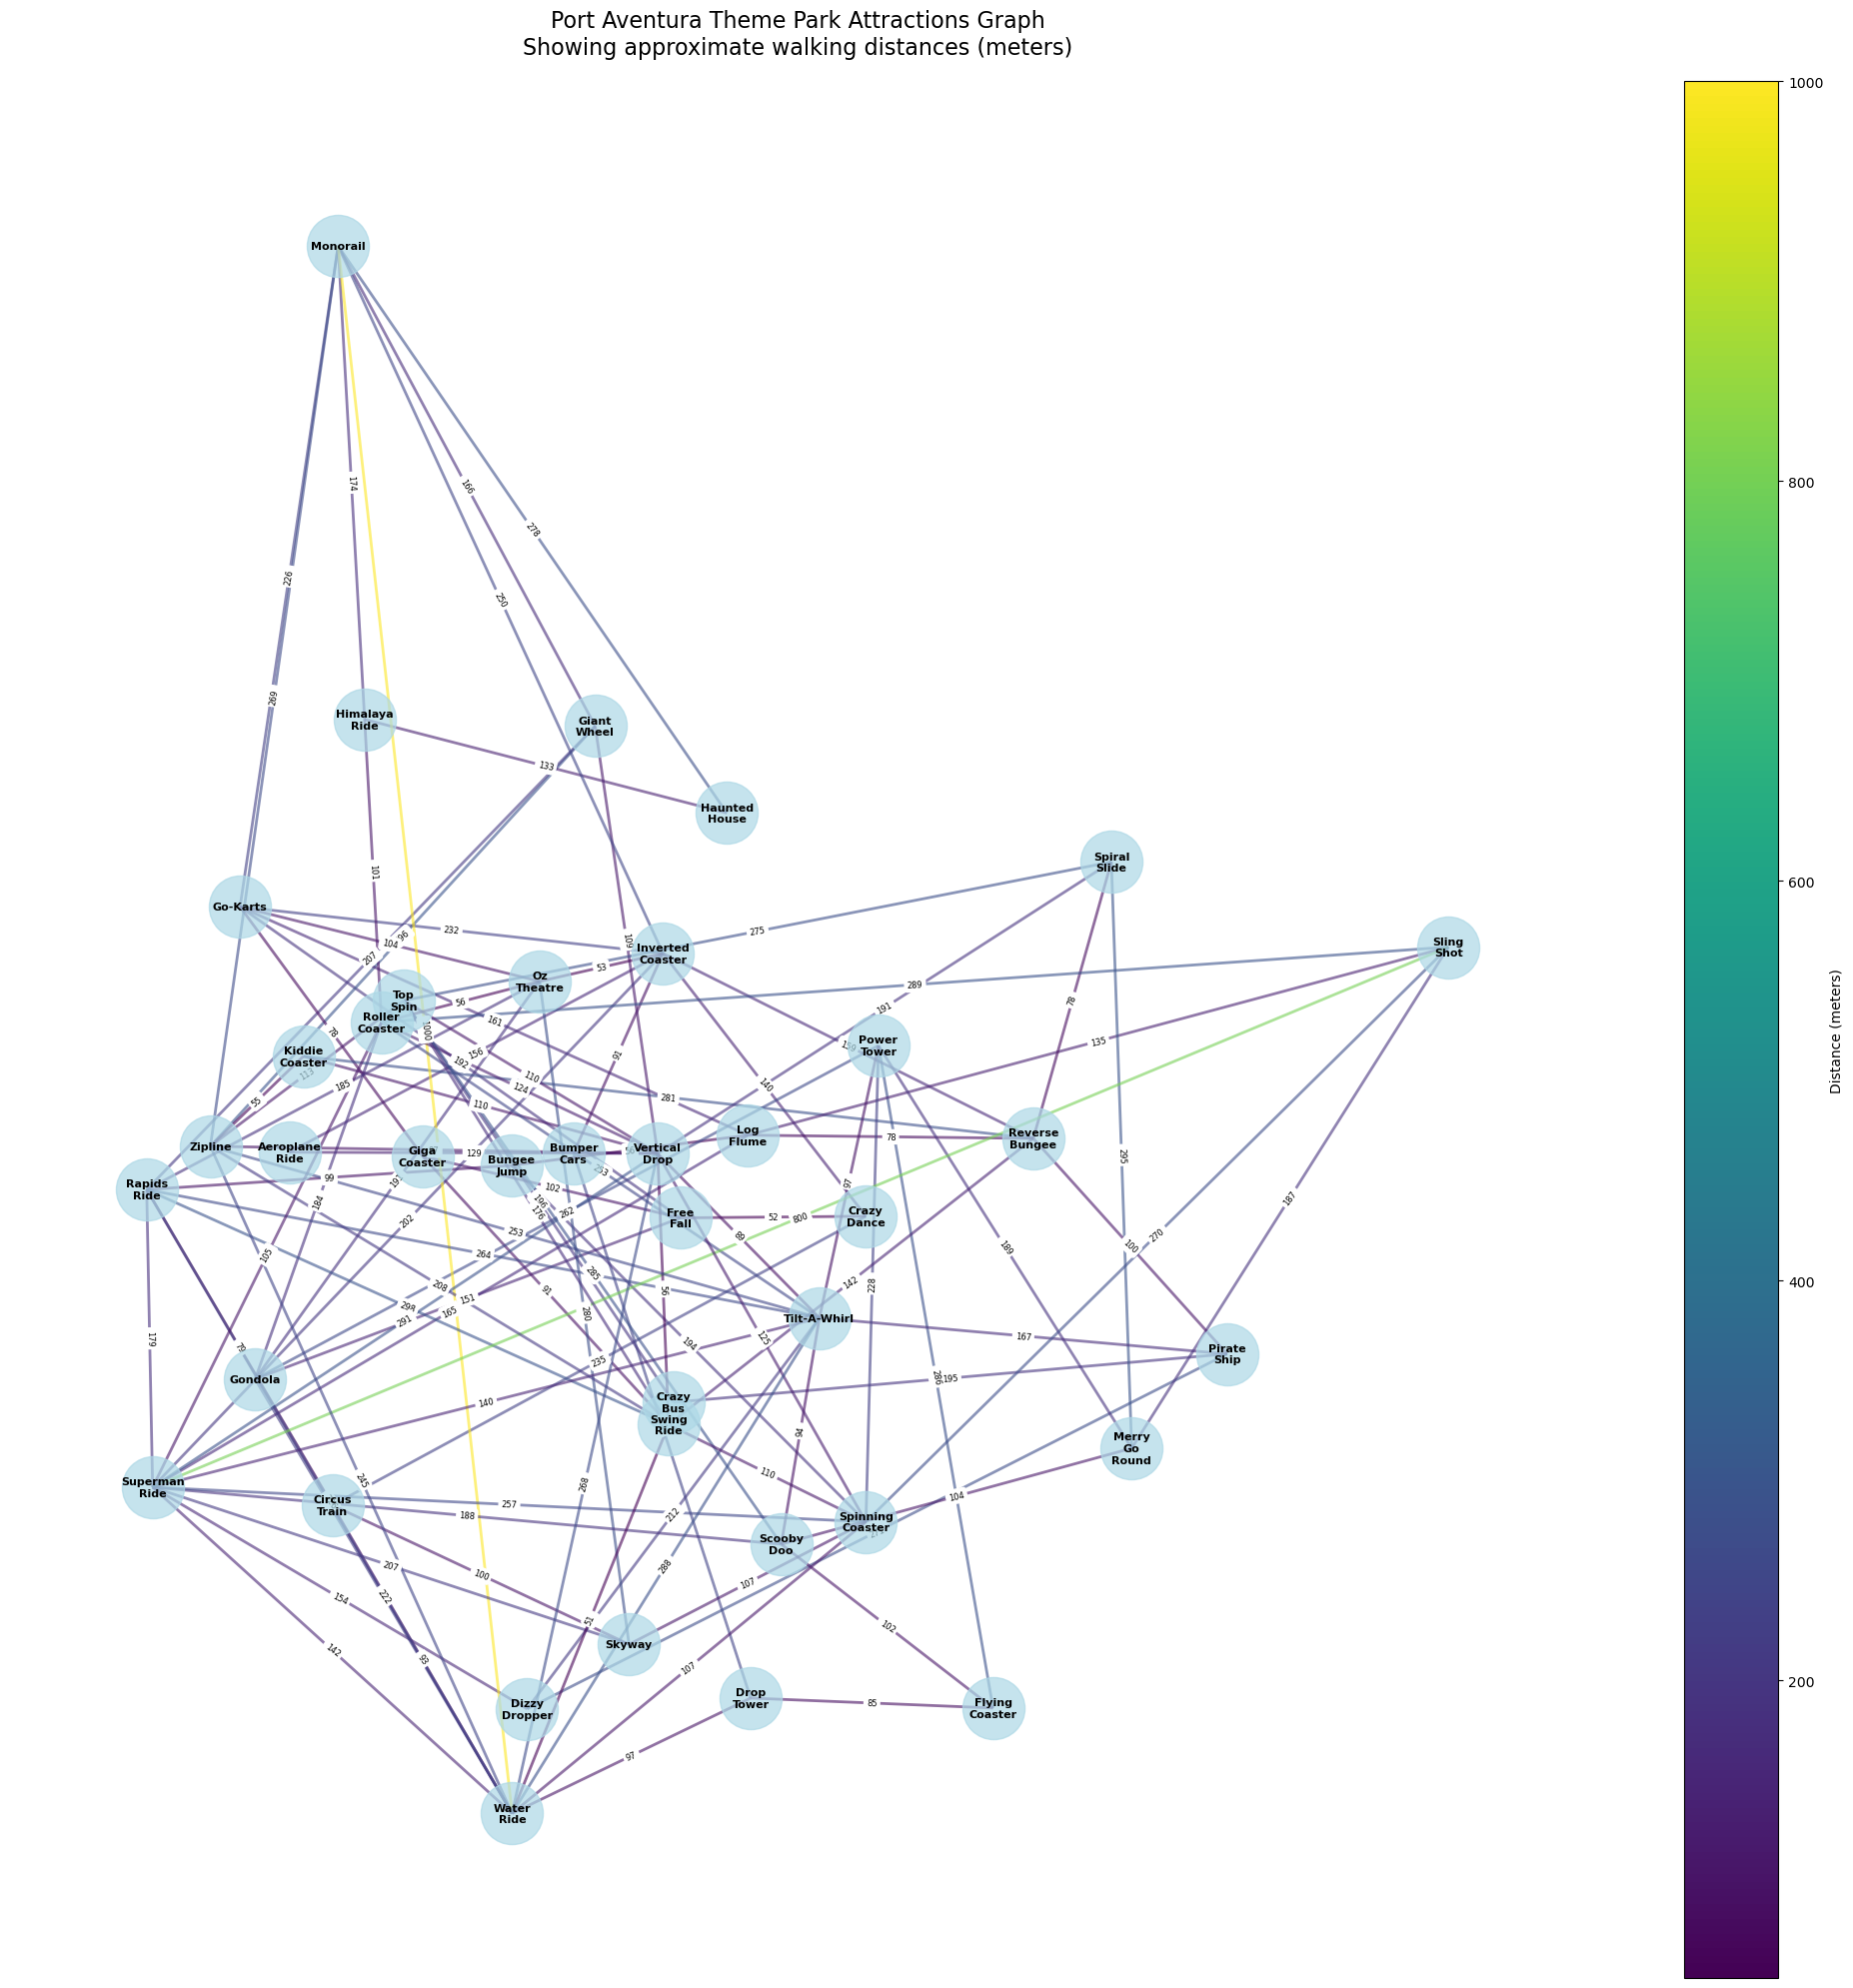

In [32]:
Both_parks = ThemeParkGraph(unique_attractions)

for attr1, attr2, distance in essential_distances:
    Both_parks.add_manual_distance(attr1, attr2, distance)
        
Both_parks.generate_paths()
Both_parks.visualize(use_distance_layout=True)  # Set to True for distance-based layout

### A graph of all the attractions in Port Aventura Park (excluding those not in Tivoli Gardens)

C:\Users\35387\AppData\Local\Temp\ipykernel_2224\452421731.py:110: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Distance (meters)')


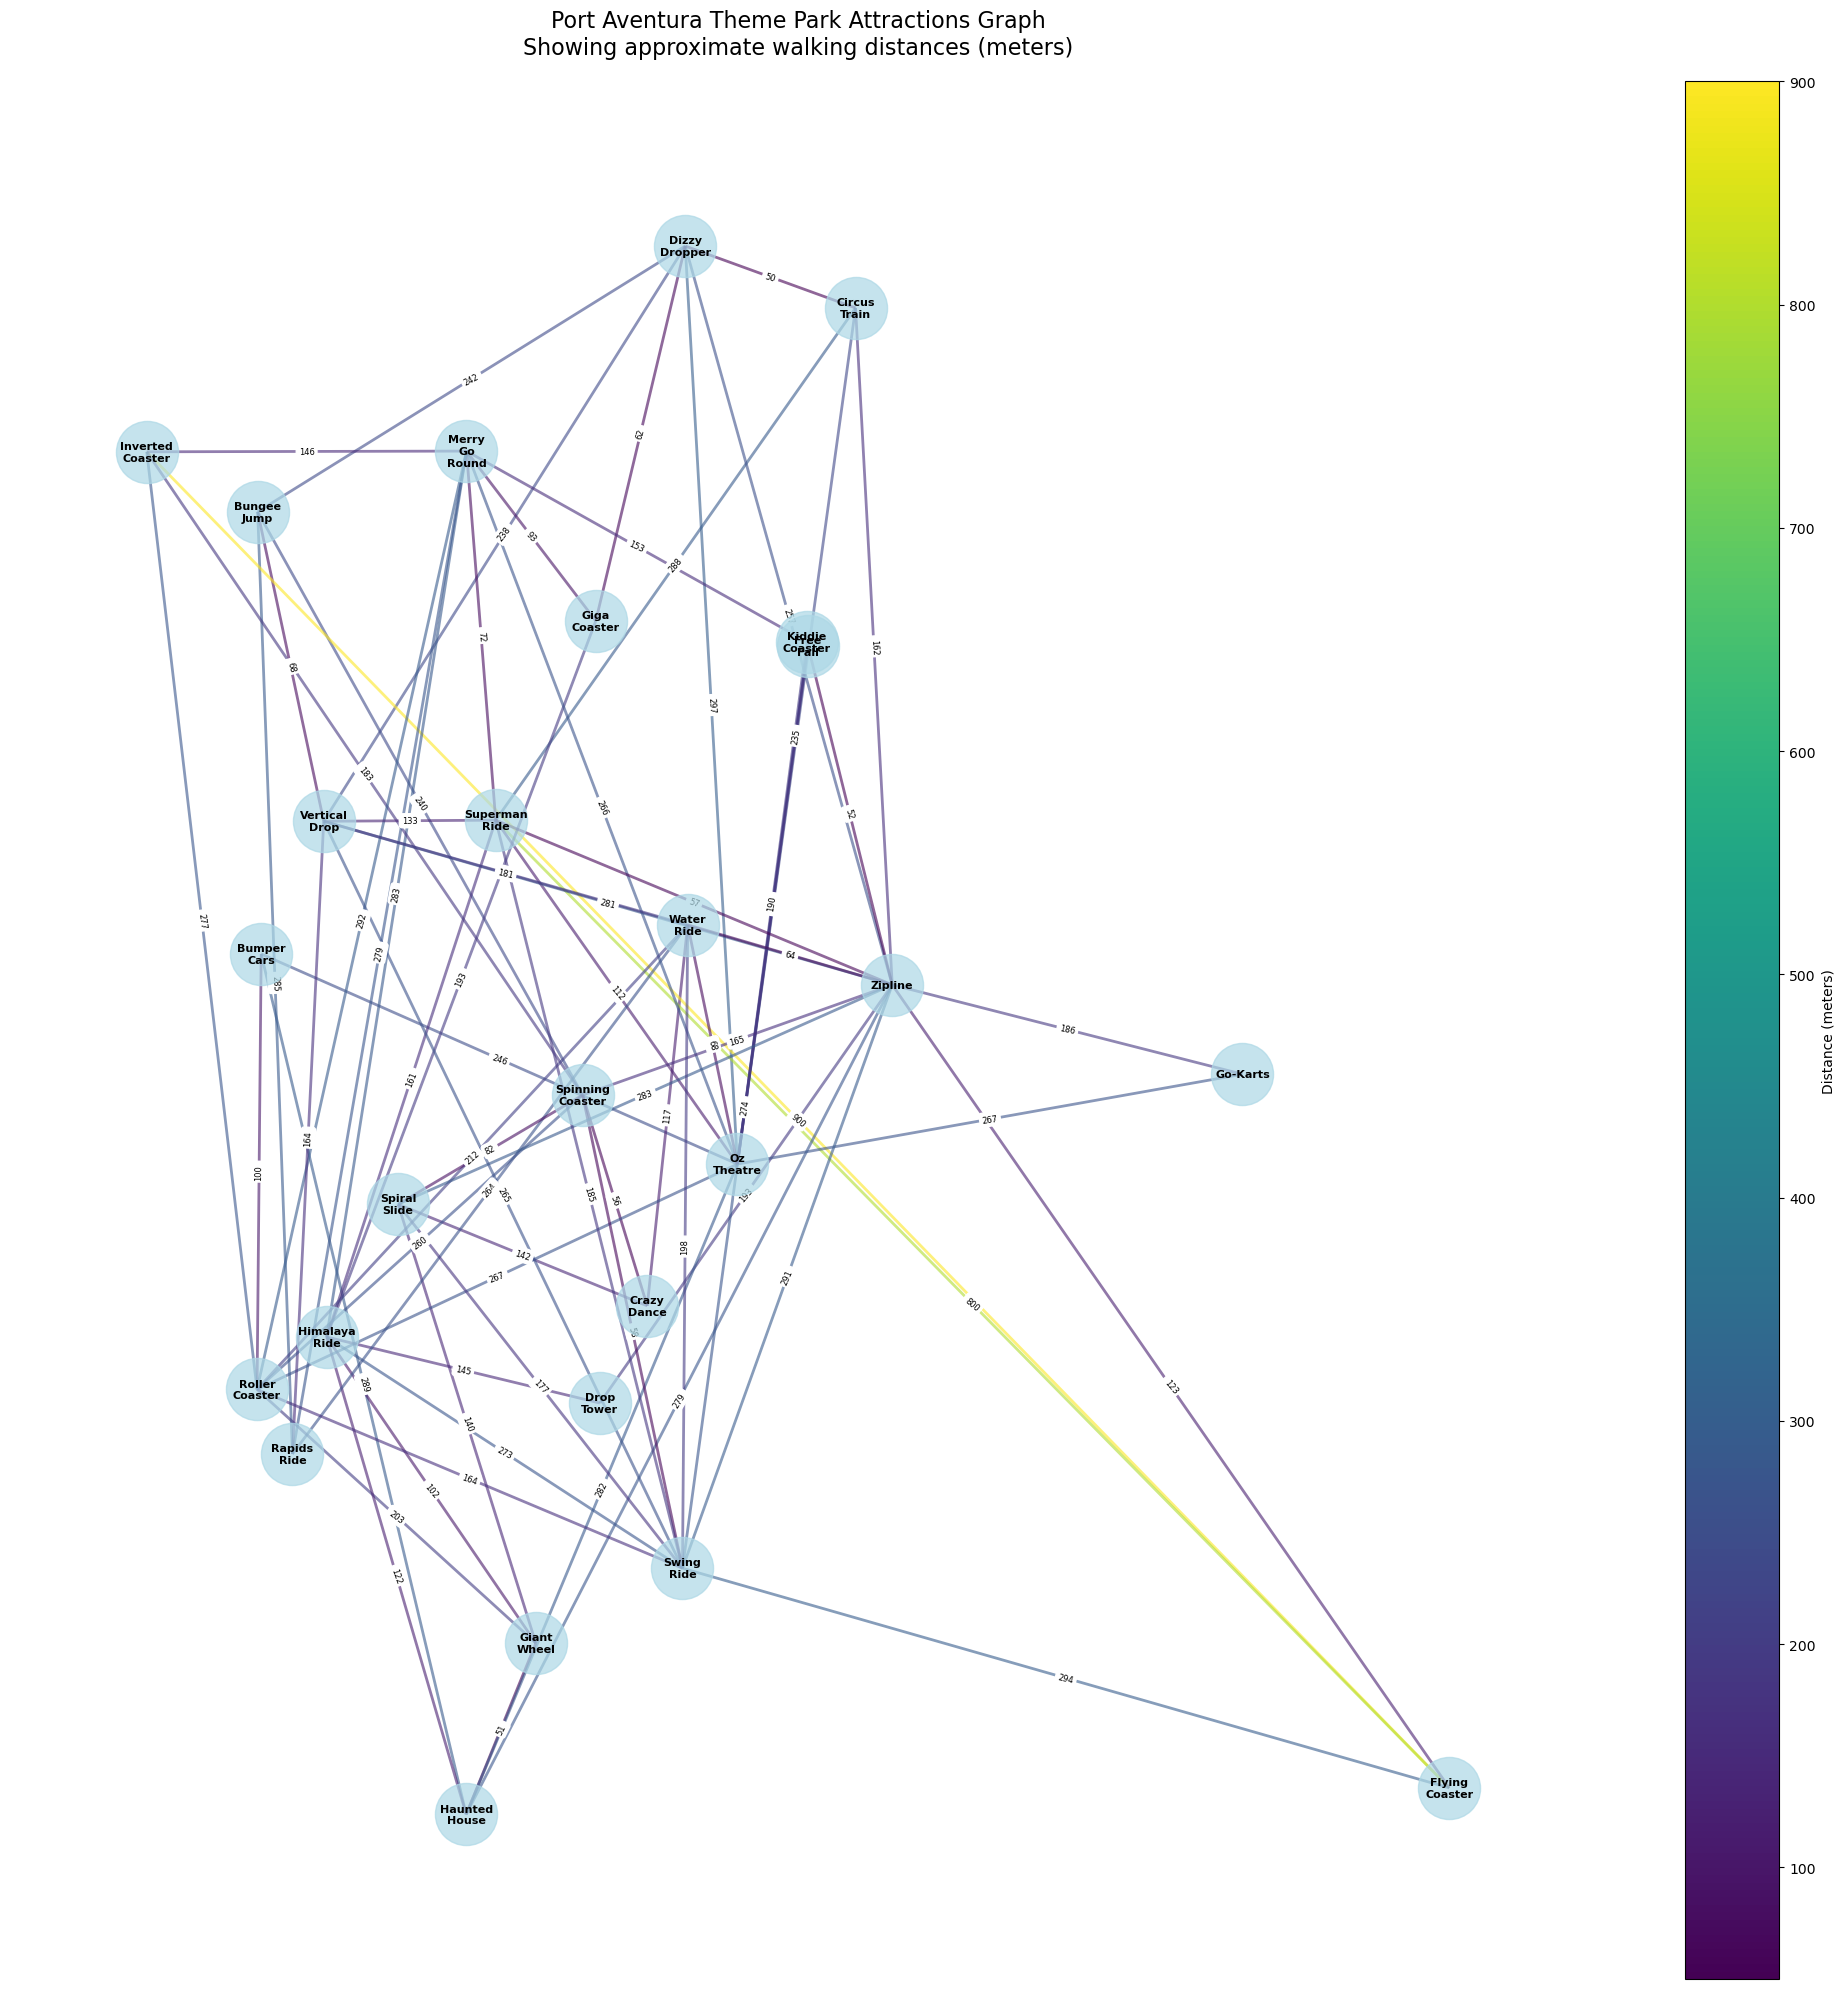

In [34]:
PortAventura_attractions = list(link_attraction[link_attraction['PARK'] == 'PortAventura World']['ATTRACTION'])

PortAventura_park = ThemeParkGraph(PortAventura_attractions)

for attr1, attr2, distance in essential_distances:
    if attr1 and attr2 in PortAventura_attractions:  # Exclude Tivoli Gardens
        PortAventura_park.add_manual_distance(attr1, attr2, distance)
        
PortAventura_park.generate_paths()
PortAventura_park.visualize(use_distance_layout=True)  # Set to True for distance-based layout
